<a href="https://colab.research.google.com/github/NirantK/span_cat_demo/blob/main/spaCy_GPU_TFM_CoNLL2003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get and Build spaCy

In [ ]:
%cd /content/
!git clone https://github.com/explosion/spacy
%cd /content/spacy
!git checkout feature/span-categorizer-v3

In [ ]:
!pip install -r requirements.txt
!pip install --no-build-isolation --editable .
!pip install spacy-transformers

In [3]:
import spacy
from spacy.tokens import DocBin, Doc
nlp = spacy.blank("en")

## Get Span Categorizer Demo Files

In [ ]:
%cd /content/
!git clone https://github.com/NirantK/span_cat_demo

In [5]:
%cd /content/spacy/
!git pull -a
%cd /content/span_cat_demo/conll2003
!python -m spacy project assets
!git pull -a
!rm -rv ./metrics/spancat_roc.json
!python -m spacy project run all

/content/spacy
Already up to date.
/content/span_cat_demo/conll2003
2021-06-28 07:39:14.853935: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Fetching 3 asset(s)
✔ Downloaded asset
/content/span_cat_demo/conll2003/assets/conll2003/train.iob
✔ Downloaded asset
/content/span_cat_demo/conll2003/assets/conll2003/dev.iob
✔ Downloaded asset
/content/span_cat_demo/conll2003/assets/conll2003/test.iob
Already up to date.
rm: cannot remove './metrics/spancat_roc.json': No such file or directory
2021-06-28 07:39:18.909091: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Running workflow 'all'

=================================== corpus ===================================
Running command: /usr/bin/python3 -m spacy convert assets/conll2003 corpus/ -n 10
2021-06-28 07:39:21.546688: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfull

# Calculate RoC AuC Scores
---
## Get Predictions

In [6]:
import numpy as np
from spacy.util import registry
from typing import List, Callable, Optional, Dict, Tuple
from thinc.api import Ops, get_current_ops, to_numpy
from thinc.types import Ragged
from pathlib import Path
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [7]:
span_nlp, loc  = spacy.load("./training/model-best"), Path("./corpus/test.spacy")
transformer = span_nlp.get_pipe("transformer")
spancat = span_nlp.get_pipe("spancat")

In [8]:
lang = "en"
nlp = spacy.blank(lang)

doc_bin = DocBin().from_disk(loc)
docs = list(doc_bin.get_docs(nlp.vocab))

In [9]:
%%time
batch = transformer.pipe(docs)
outputs = spancat.predict(list(batch))

CPU times: user 2min 41s, sys: 3.9 s, total: 2min 45s
Wall time: 2min 44s


## Get Ground Truth (Y_TRUE) and Predictions (Y_PRED)

In [10]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [11]:
def get_true_spans(docs: List[Doc])->np.array:
    doc_ent_pos, lengths, labels = [], [], []
    for doc in docs:
        ent_pos = [[ent.start, ent.end] for ent in doc.ents]
        ent_labels = [ent.label_ for ent in doc.ents]
        doc_ent_pos.extend(ent_pos)
        lengths.append(len(ent_pos))
        labels.extend(ent_labels)
    return Ragged(np.array(doc_ent_pos), np.array(lengths)), np.array(labels)

true_spans, true_labels = get_true_spans(docs)

In [13]:
def get_roc_auc(pred_spans:Ragged, pred_scores: np.array, true_spans: Ragged, true_labels: np.array)->Dict[str, Dict[str, np.array]]:
    pred_indices, pred_lengths = pred_spans.data, pred_spans.lengths
    true_indices, true_lengths = true_spans.data, true_spans.lengths
    assert type(pred_indices) == type(pred_lengths) == type(true_indices) == type(true_lengths)
    
    suggest_start, ent_start = 0, 0
    docs_y_true = []

    # This is right O(m*n) which is inefficient, there has to be a numpy way e.g. isin or intersect1d way to do this faster
    for suggested_count, entities_count in zip(pred_lengths, true_lengths):
        suggestions = pred_indices[suggest_start: suggest_start+suggested_count]
        suggest_start += suggested_count
        entities = true_indices[ent_start: ent_start+entities_count]
        labels = true_labels[ent_start: ent_start+entities_count]
        ent_start += entities_count
        y_true = []
        for suggested_span in suggestions:
            flag = False
            for ent, label in zip(entities, labels):
                if not flag:
                    flag = (ent == suggested_span).all()
                    if flag:
                        y_true.append(label)
                        ent_found = True
            if not flag:
                y_true.append(0)
        docs_y_true.extend(y_true)

    sum_one = np.array([sigmoid(x) for x in pred_scores])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    pr = dict()
    auc_dict = {}
    for idx, key in enumerate(spancat.label_data):
        cls_y_true = np.array([1 if element == "LOC" else 0 for element in docs_y_true])
        cls_y_score = np.array([score[idx] for score in sum_one])
        auc_score = roc_auc_score(y_true=cls_y_true, y_score=cls_y_score)
        fpr[key], tpr[key], _ =  roc_curve(y_true=cls_y_true, y_score=cls_y_score)
        precision, recall, _ = precision_recall_curve(y_true=cls_y_true, probas_pred=cls_y_score)
        pr[key] = {"precision": precision, "recall": recall}
        auc_dict[key] = auc_score
    
    return auc_dict, fpr, tpr, pr

pred_spans, pred_scores = outputs
auc, fpr, tpr, pr = get_roc_auc(pred_spans, pred_scores, true_spans, true_labels)

# RoC and AUC

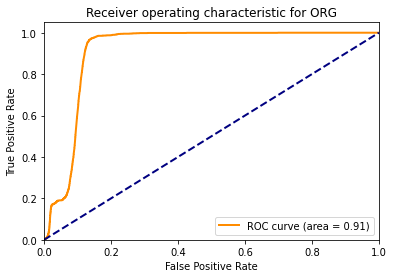

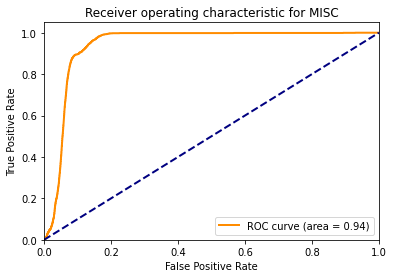

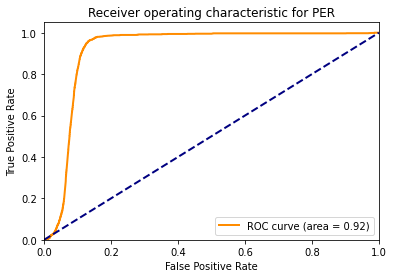

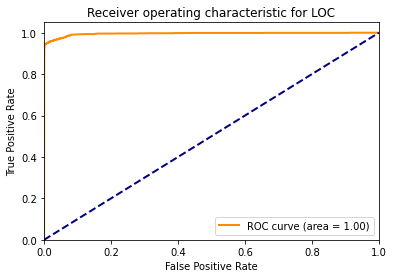

In [14]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

lw = 2 # linewidht
for key in spancat.label_data:
    plt.figure()
    # pr_display = PrecisionRecallDisplay(precision=pr[key]["precision"], recall=pr[key]["recall"], average_precision=None, estimator_name=None).plot()
    plt.plot(fpr[key], tpr[key], color='darkorange', lw=lw, label=f"ROC curve (area = {auc[key]:0.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver operating characteristic for {key}")
    plt.legend(loc="lower right")

plt.show()